# Importing Relevant Libraries

In [1]:
!pip install torchsummary
!pip install watermark

In [2]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import torch
from torchsummary import summary
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torchvision.models as models 
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import ConcatDataset
from torch.utils.tensorboard import SummaryWriter

In [3]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [4]:
from watermark import watermark

# Printing versions of libraries used
%load_ext watermark
%watermark -v -p torch,torchvision,torchsummary,numpy,matplotlib,PIL

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.21.0

torch       : 2.4.0
torchvision : 0.19.0
torchsummary: 1.5.1
numpy       : 1.26.4
matplotlib  : 3.7.5
PIL         : 10.4.0



# Getting Dataset Ready

In [5]:
class AeroHeliDataset(Dataset):
    def __init__(self, root_dir, train=True, train_transform=None, test_transform=None):
        """
        Args:
            root_dir (string): Path to the dataset directory.
            train (bool): If True, loads the training data. If False, loads the test data.
            train_transform (callable, optional): Transformations for training data.
            test_transform (callable, optional): Transformations for test data.
        """
        self.root_dir = root_dir
        self.train = train
        self.train_transform = train_transform
        self.test_transform = test_transform
        
        # The list of images and labels
        self.images = []
        self.labels = []
        
        # Set directory based on whether this is training or testing data
        data_type = 'train' if self.train else 'test'
        
        # Load images and labels
        for label, class_name in enumerate(['aero', 'heli']):  # 0 for 'aero', 1 for 'heli'
            class_dir = os.path.join(root_dir, data_type, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith(".jpg"):  
                    self.images.append(os.path.join(class_dir, filename))
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        
        # Open the image
        image = Image.open(image_path).convert("RGB")
        
        # Apply appropriate transformations
        if self.train and self.train_transform:
            image = self.train_transform(image)
        elif not self.train and self.test_transform:
            image = self.test_transform(image)
        
        return image, label


In [6]:
# Defining different transforms for different models

basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing images to 224x224
    transforms.ToTensor()
])

augmented_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # Augmentation
    transforms.RandomHorizontalFlip(),  
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.ToTensor(),
])

In [7]:
root_dir = "/kaggle/input/aeroplane-helicopter-image-classification/dataset_aero_heli"

In [8]:
# Training datasets for each type
train_dataset_basic = AeroHeliDataset(root_dir=root_dir, train=True, train_transform=basic_transform)

only_augmented_1 = AeroHeliDataset(root_dir=root_dir, train=True, train_transform=augmented_transform)
only_augmented_2 = AeroHeliDataset(root_dir=root_dir, train=True, train_transform=augmented_transform)
train_dataset_augmented = ConcatDataset([train_dataset_basic, only_augmented_1, only_augmented_2]) # Concatinating extra augments

# Corresponding test datasets for each type (without augmentation)
test_dataset_basic = AeroHeliDataset(root_dir=root_dir, train=False, test_transform=basic_transform)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Visualizing the Data

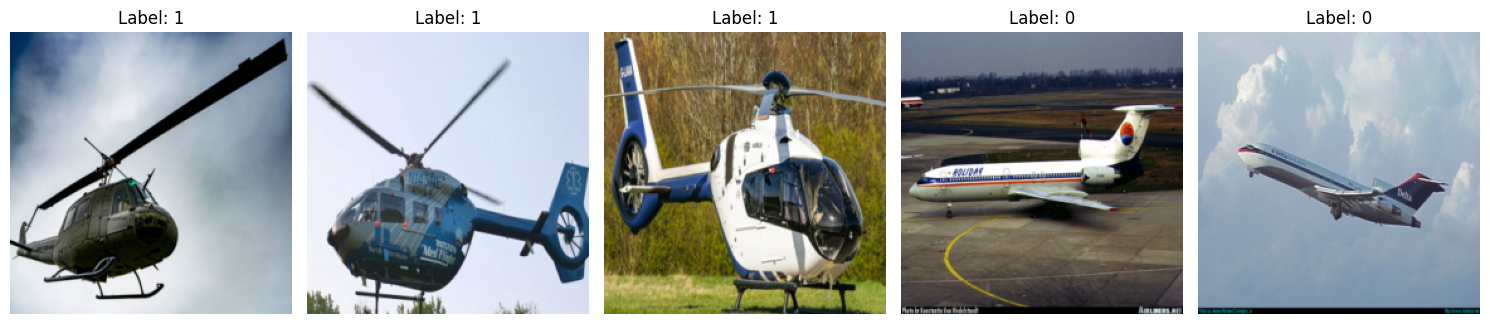

In [10]:
# Function to visualize random samples from the dataset
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    # Get random indices
    random_indices = random.sample(range(len(dataset)), num_samples)
    
    for i, idx in enumerate(random_indices):
        img, label = dataset[idx]

        # Convert the image tensor to a PIL image (if it’s a tensor)
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}")

    plt.tight_layout()
    plt.show()

# Call the function
visualize_samples(train_dataset_basic, num_samples=5)


# Defining Different Models

In [11]:
# 1 Block model

class Model1Block(nn.Module):
    def __init__(self):
        super(Model1Block, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 112 * 112, 128)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # Flatten
        x = self.flatten(x)
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        
        return x

summary(Model1Block().to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
           Flatten-3               [-1, 401408]               0
            Linear-4                  [-1, 128]      51,380,352
            Linear-5                    [-1, 1]             129
Total params: 51,381,377
Trainable params: 51,381,377
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 18.38
Params size (MB): 196.00
Estimated Total Size (MB): 214.95
----------------------------------------------------------------


In [ ]:
 # 3 Block model

class Model3Block(nn.Module):
    def __init__(self):
        super(Model3Block, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Block 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Block 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)        
        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # Block 2
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # Block 3
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        # Flatten
        x = self.flatten(x)
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        
        return x
        
summary(Model3Block().to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
         MaxPool2d-6          [-1, 128, 28, 28]               0
           Flatten-7               [-1, 100352]               0
            Linear-8                  [-1, 128]      12,845,184
            Linear-9                    [-1, 1]             129
Total params: 12,938,561
Trainable params: 12,938,561
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 27.56
Params size (MB): 49.36
Estimated Total Size (MB): 77.49
----------------------------------

## VGG 16
VGG-16 architecture is commonly referenced as having 16 "layers," but this count includes only the weighted layers (i.e., Conv2D and Linear layers). The non-weighted layers like ReLU, MaxPooling, and Dropout are not included in this count.

In [ ]:
# Transfer learning using VGG16  with tuning all layers (including tuning convolution layers)

class VGGModel(nn.Module):
    def __init__(self):
        super(VGGModel, self).__init__()
        # Load VGG16 model with pretrained weights, including the classifier (fully connected) layers
        self.vgg16 = models.vgg16(weights='VGG16_Weights.DEFAULT')
        
        # Set all layers as trainable
        for param in self.vgg16.features.parameters():
            param.requires_grad = True
        
        # Modify the final fully connected layer in the classifier for binary classification
        num_features = self.vgg16.classifier[-1].in_features
        self.vgg16.classifier[-1] = nn.Linear(num_features, 1)
        
    def forward(self, x):
        # Forward pass through the entire model, including modified classifier
        x = self.vgg16(x)
        x = torch.sigmoid(x)
        return x

summary(VGGModel().to(device), input_size=(3, 224, 224))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 220MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# Transfer learning using VGG16 or VGG19 with tuning only final MLP layers (excluding convolution layers)

class VGGModel_1(nn.Module):
    def __init__(self):
        super(VGGModel_1, self).__init__()
        # Load VGG16 model with pretrained weights, including the classifier (fully connected) layers
        self.vgg16 = models.vgg16(weights='VGG16_Weights.DEFAULT')
        
        # Freeze all convolutional (feature extraction) layers, making them non-trainable
        for param in self.vgg16.features.parameters():
            param.requires_grad = False
        
        # For freezing FC layers use vgg16.classifier.parameters
        
        # Modify the final fully connected layer in the classifier for binary classification
        num_features = self.vgg16.classifier[-1].in_features
        self.vgg16.classifier[-1] = nn.Linear(num_features, 1)
    
    def forward(self, x):
        # Forward pass through the entire model, including modified classifier
        x = self.vgg16(x)
        x = torch.sigmoid(x)
        return x
        
summary(VGGModel_1().to(device), [(3, 224, 224)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [15]:
def get_model(model_name):
    if model_name == "1_block":
        model = Model1Block()
    elif model_name == "3_block":
        model = Model3Block()
    elif model_name == "3_block_aug":
        model = Model3Block()
    elif model_name == "vgg_16":
        model = VGGModel()
    elif model_name == "vgg_16_1":
        model = VGGModel_1()
    else:
        raise ValueError(f"Model {model_name} is not defined")
    return model

# Training and Evaluation

In [16]:
# Hyperparameters
num_epochs = 10
batch_size = 16
learning_rate = 1e-4

In [ ]:
def log_images_with_predictions(dataset, targets, predictions, writer, step):
    num_images = len(targets)
    cols = 8
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 2.5 * rows))
    axes = axes.flatten()

    for idx in range(num_images):
        img, true_label, pred_label = dataset[idx][0], targets[idx].item(), predictions[idx].item()
        # Convert to (H, W, C) format
        img = img.permute(1, 2, 0).cpu().numpy()  

        ax = axes[idx]
        ax.imshow(img)
        ax.axis('off')

        # Set title with true/pred labels
        title_color = "green" if true_label == pred_label else "red"
        ax.set_title(f"True: {int(true_label)} | Pred: {int(pred_label)}", color=title_color)

    # Turn off any unused axes (in case num_images is not a multiple of cols)
    for ax in axes[num_images:]:
        ax.axis('off')

    # Save and log the plot to TensorBoard
    plt.tight_layout()
    plt_path = "temp_plot_final_epoch.jpg"
    plt.savefig(plt_path, bbox_inches='tight', format='jpg')
    plt.close(fig)

    # Load the image and add to TensorBoard
    pil_img = Image.open(plt_path)
    img_np = np.array(pil_img)
    writer.add_image("Test Images with Predictions", img_np.transpose(2, 0, 1), global_step=step)


In [ ]:
def train_and_evaluate(model_name, train_dataset, test_dataset,num_epochs = 10, batch_size = 16, learning_rate = 1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize model
    model = get_model(model_name)
    model.to(device)

    # Define loss and optimizer
    criterion = nn.BCELoss()  
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)

    # TensorBoard writers
    writer_train = SummaryWriter(f"runs/{model_name}_Train")
    writer_test = SummaryWriter(f"runs/{model_name}_Test")

    # Log model graph for first iteration
    images, _ = next(iter(train_loader))
    writer_train.add_graph(model, images.to(device))
    
    step_train, step_test = 0, 0

    # Total time required for test phase (summed over each iteration)
    total_test_time = 0

    # Initialize lists to accumulate losses and accuracies
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    model_dir = "/kaggle/working/saved_models"
    os.makedirs(model_dir, exist_ok=True)
    
    epoch_start_time = time.time()
    
    # Training and evaluation loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        for batch_idx, (data, targets) in enumerate(train_loader):    
            data = torch.tensor(data, dtype=torch.float32).to(device)
            targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(1).to(device)
            
            # Forward pass
            scores = model(data)
            loss = criterion(scores, targets)
            train_losses.append(loss.item())
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            predictions = (scores > 0.5).float()  
            correct = (predictions == targets).sum().item()
            accuracy = correct / data.shape[0]
            train_accuracies.append(accuracy)

            # Log to TensorBoard for training
            writer_train.add_scalar("Loss", loss.item(), global_step=step_train)
            writer_train.add_scalar("Accuracy", accuracy, global_step=step_train)
            step_train += 1
            ### One iteration(batch) of training completed ###
        
            # Test phase (no gradients needed)
            test_start_time = time.time()
            model.eval()
            with torch.no_grad():
                for data, targets in test_loader:
                    data = torch.tensor(data, dtype=torch.float32).to(device)
                    targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(1).to(device)
                    
                    # Forward pass
                    scores = model(data)
                    loss = criterion(scores, targets)
    
                    # Calculating test accuracy
                    predictions = (scores > 0.5).float() 
                    correct = (predictions == targets).sum().item()
                    accuracy = correct / data.shape[0]
                    test_accuracies.append(accuracy)
    
                    # Log to TensorBoard for testing
                    writer_test.add_scalar("Accuracy", accuracy, global_step=step_test)
                    step_test += 1 
                    
            test_end_time = time.time()
            total_test_time += test_end_time - test_start_time
        
        # Calculate and print the epoch metrics
        avg_train_loss = sum(train_losses) / len(train_losses)
        avg_train_acc = sum(train_accuracies) / len(train_accuracies)
        avg_test_acc = sum(test_accuracies) / len(test_accuracies)

        print(f"\nEpoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Train Accuracy: {avg_train_acc:.4f}, "
              f"Test Accuracy: {avg_test_acc:.4f}, ")

    epoch_end_time = time.time()
    # Total Time required for all epochs (train+test)
    total_epoch_time = epoch_end_time - epoch_start_time
    # Total Time required for training phase
    total_training_time = total_epoch_time - total_test_time 
    
    # Save final model
    torch.save(model.state_dict(), os.path.join(model_dir, f"{model_name}_final.pth"))
    
    print(f"\n------------\nTotal Training Time: {total_training_time:.4f} seconds \n-------------")  
    print(f"\n------------\nAverage Training Time (per epoch): {(total_training_time / num_epochs):.4f} seconds per epoch \n-------------")

    # Now that training is complete, let's predict on the test set using the trained model
    model.eval()  # Set the model to evaluation mode
    test_loader2 = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    predictions_list = []
    targets_list = []
    
    with torch.no_grad():
        for data, targets in test_loader2:
            data = torch.tensor(data, dtype=torch.float32).to(device)
            targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(1).to(device)
            
            # Forward pass
            scores = model(data)
            predictions = (scores > 0.5).float()  
            
            predictions_list.append(predictions.cpu())
            targets_list.append(targets.cpu())

    # Concatenate all predictions and targets
    all_predictions = torch.cat(predictions_list, dim=0)
    all_targets = torch.cat(targets_list, dim=0)

    # Log the predictions to TensorBoard after training is complete
    log_images_with_predictions(test_dataset, all_targets, all_predictions, writer_test, step_test)
    
    # Close the writers
    writer_train.close()
    writer_test.close()

In [19]:
train_and_evaluate(model_name="1_block", train_dataset=train_dataset_basic, test_dataset=test_dataset_basic)


Epoch [1/10] - Train Loss: 0.8753, Train Accuracy: 0.6125, Test Accuracy: 0.6500, 

Epoch [2/10] - Train Loss: 0.5785, Train Accuracy: 0.7500, Test Accuracy: 0.7512, 

Epoch [3/10] - Train Loss: 0.4559, Train Accuracy: 0.8063, Test Accuracy: 0.7875, 

Epoch [4/10] - Train Loss: 0.4056, Train Accuracy: 0.8281, Test Accuracy: 0.7975, 

Epoch [5/10] - Train Loss: 0.3481, Train Accuracy: 0.8525, Test Accuracy: 0.8220, 

Epoch [6/10] - Train Loss: 0.3022, Train Accuracy: 0.8750, Test Accuracy: 0.8438, 

Epoch [7/10] - Train Loss: 0.2674, Train Accuracy: 0.8920, Test Accuracy: 0.8607, 

Epoch [8/10] - Train Loss: 0.2400, Train Accuracy: 0.9055, Test Accuracy: 0.8734, 

Epoch [9/10] - Train Loss: 0.2177, Train Accuracy: 0.9160, Test Accuracy: 0.8844, 

Epoch [10/10] - Train Loss: 0.1999, Train Accuracy: 0.9237, Test Accuracy: 0.8927, 

------------
Total Training Time: 87.8308 seconds 
-------------

------------
Average Training Time (per epoch): 8.7831 seconds per epoch 
-------------


In [20]:
train_and_evaluate(model_name="3_block", train_dataset=train_dataset_basic, test_dataset=test_dataset_basic)


Epoch [1/10] - Train Loss: 0.6884, Train Accuracy: 0.5062, Test Accuracy: 0.5450, 

Epoch [2/10] - Train Loss: 0.6532, Train Accuracy: 0.5719, Test Accuracy: 0.6088, 

Epoch [3/10] - Train Loss: 0.5941, Train Accuracy: 0.6479, Test Accuracy: 0.6833, 

Epoch [4/10] - Train Loss: 0.5358, Train Accuracy: 0.7078, Test Accuracy: 0.7225, 

Epoch [5/10] - Train Loss: 0.4889, Train Accuracy: 0.7425, Test Accuracy: 0.7490, 

Epoch [6/10] - Train Loss: 0.4458, Train Accuracy: 0.7719, Test Accuracy: 0.7696, 

Epoch [7/10] - Train Loss: 0.4065, Train Accuracy: 0.7982, Test Accuracy: 0.7914, 

Epoch [8/10] - Train Loss: 0.3713, Train Accuracy: 0.8195, Test Accuracy: 0.8103, 

Epoch [9/10] - Train Loss: 0.3404, Train Accuracy: 0.8368, Test Accuracy: 0.8258, 

Epoch [10/10] - Train Loss: 0.3133, Train Accuracy: 0.8519, Test Accuracy: 0.8383, 

------------
Total Training Time: 85.1766 seconds 
-------------

------------
Average Training Time (per epoch): 8.5177 seconds per epoch 
-------------


In [21]:
train_and_evaluate(model_name="3_block_aug", train_dataset=train_dataset_augmented, test_dataset=test_dataset_basic)


Epoch [1/10] - Train Loss: 0.5954, Train Accuracy: 0.6833, Test Accuracy: 0.7025, 

Epoch [2/10] - Train Loss: 0.5096, Train Accuracy: 0.7427, Test Accuracy: 0.7696, 

Epoch [3/10] - Train Loss: 0.4232, Train Accuracy: 0.7986, Test Accuracy: 0.8222, 

Epoch [4/10] - Train Loss: 0.3505, Train Accuracy: 0.8417, Test Accuracy: 0.8577, 

Epoch [5/10] - Train Loss: 0.2961, Train Accuracy: 0.8692, Test Accuracy: 0.8803, 

Epoch [6/10] - Train Loss: 0.2561, Train Accuracy: 0.8885, Test Accuracy: 0.8958, 

Epoch [7/10] - Train Loss: 0.2238, Train Accuracy: 0.9042, Test Accuracy: 0.9076, 

Epoch [8/10] - Train Loss: 0.1987, Train Accuracy: 0.9159, Test Accuracy: 0.9160, 

Epoch [9/10] - Train Loss: 0.1792, Train Accuracy: 0.9248, Test Accuracy: 0.9229, 

Epoch [10/10] - Train Loss: 0.1624, Train Accuracy: 0.9321, Test Accuracy: 0.9281, 

------------
Total Training Time: 272.8650 seconds 
-------------

------------
Average Training Time (per epoch): 27.2865 seconds per epoch 
-------------


In [22]:
train_and_evaluate(model_name="vgg_16", train_dataset=train_dataset_basic, test_dataset=test_dataset_basic, num_epochs = 10)


Epoch [1/10] - Train Loss: 0.2357, Train Accuracy: 0.9187, Test Accuracy: 0.9700, 

Epoch [2/10] - Train Loss: 0.1186, Train Accuracy: 0.9594, Test Accuracy: 0.9637, 

Epoch [3/10] - Train Loss: 0.0791, Train Accuracy: 0.9729, Test Accuracy: 0.9692, 

Epoch [4/10] - Train Loss: 0.0594, Train Accuracy: 0.9797, Test Accuracy: 0.9763, 

Epoch [5/10] - Train Loss: 0.0475, Train Accuracy: 0.9838, Test Accuracy: 0.9760, 

Epoch [6/10] - Train Loss: 0.0396, Train Accuracy: 0.9865, Test Accuracy: 0.9758, 

Epoch [7/10] - Train Loss: 0.0339, Train Accuracy: 0.9884, Test Accuracy: 0.9757, 

Epoch [8/10] - Train Loss: 0.0297, Train Accuracy: 0.9898, Test Accuracy: 0.9756, 

Epoch [9/10] - Train Loss: 0.0264, Train Accuracy: 0.9910, Test Accuracy: 0.9756, 

Epoch [10/10] - Train Loss: 0.0237, Train Accuracy: 0.9919, Test Accuracy: 0.9755, 

------------
Total Training Time: 95.6221 seconds 
-------------

------------
Average Training Time (per epoch): 9.5622 seconds per epoch 
-------------


In [23]:
train_and_evaluate(model_name="vgg_16_1", train_dataset=train_dataset_basic, test_dataset=test_dataset_basic, num_epochs =  10)


Epoch [1/10] - Train Loss: 0.1956, Train Accuracy: 0.9375, Test Accuracy: 0.9700, 

Epoch [2/10] - Train Loss: 0.0998, Train Accuracy: 0.9688, Test Accuracy: 0.9813, 

Epoch [3/10] - Train Loss: 0.0665, Train Accuracy: 0.9792, Test Accuracy: 0.9775, 

Epoch [4/10] - Train Loss: 0.0499, Train Accuracy: 0.9844, Test Accuracy: 0.9706, 

Epoch [5/10] - Train Loss: 0.0399, Train Accuracy: 0.9875, Test Accuracy: 0.9665, 

Epoch [6/10] - Train Loss: 0.0333, Train Accuracy: 0.9896, Test Accuracy: 0.9638, 

Epoch [7/10] - Train Loss: 0.0285, Train Accuracy: 0.9911, Test Accuracy: 0.9618, 

Epoch [8/10] - Train Loss: 0.0249, Train Accuracy: 0.9922, Test Accuracy: 0.9603, 

Epoch [9/10] - Train Loss: 0.0222, Train Accuracy: 0.9931, Test Accuracy: 0.9592, 

Epoch [10/10] - Train Loss: 0.0200, Train Accuracy: 0.9938, Test Accuracy: 0.9583, 

------------
Total Training Time: 87.5063 seconds 
-------------

------------
Average Training Time (per epoch): 8.7506 seconds per epoch 
-------------


In [24]:
!zip -r testing.zip runs

  adding: runs/ (stored 0%)
  adding: runs/3_block_aug_Train/ (stored 0%)
  adding: runs/3_block_aug_Train/events.out.tfevents.1731597614.743971032e7a.30.4 (deflated 72%)
  adding: runs/vgg_16_Train/ (stored 0%)
  adding: runs/vgg_16_Train/events.out.tfevents.1731598984.743971032e7a.30.6 (deflated 88%)
  adding: runs/1_block_Train/ (stored 0%)
  adding: runs/1_block_Train/events.out.tfevents.1731596681.743971032e7a.30.0 (deflated 70%)
  adding: runs/3_block_aug_Test/ (stored 0%)
  adding: runs/3_block_aug_Test/events.out.tfevents.1731597614.743971032e7a.30.5 (deflated 1%)
  adding: runs/vgg_16_1_Train/ (stored 0%)
  adding: runs/vgg_16_1_Train/events.out.tfevents.1731599459.743971032e7a.30.8 (deflated 88%)
  adding: runs/3_block_Test/ (stored 0%)
  adding: runs/3_block_Test/events.out.tfevents.1731597149.743971032e7a.30.3 (deflated 0%)
  adding: runs/3_block_Train/ (stored 0%)
  adding: runs/3_block_Train/events.out.tfevents.1731597149.743971032e7a.30.2 (deflated 76%)
  adding: runs/1_

In [25]:
!zip -r saved_models.zip saved_models

  adding: saved_models/ (stored 0%)
  adding: saved_models/3_block_final.pth (deflated 8%)
  adding: saved_models/vgg_16_final.pth (deflated 7%)
  adding: saved_models/1_block_final.pth (deflated 8%)
  adding: saved_models/vgg_16_1_final.pth (deflated 7%)
  adding: saved_models/3_block_aug_final.pth (deflated 7%)
